The rice image classification dataset is available [here](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) on Kaggle. The images are divided into 5 categories of rice i.e: Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The goal is to classify images using deep neural network. 

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Rice', seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3500 files belonging to 5 classes.


In [4]:
classnames = dataset.class_names
classnames

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

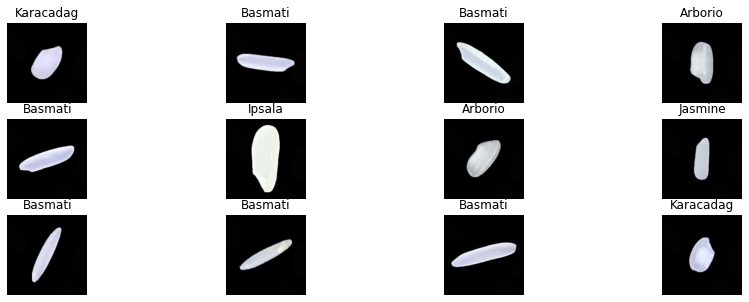

In [5]:
plt.figure(figsize=(15, 5))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classnames[label_batch[i]])
        plt.axis("off")

In [6]:
def split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=699):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size, seed=123)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [7]:
train_ds, test_ds, val_ds = split_data(dataset)

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(6, activation="softmax")
])

In [40]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [41]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=0,
    restore_best_weights=True,
)

In [42]:
history = model.fit(train_ds, batch_size=BATCH_SIZE,
                   validation_data = val_ds, callbacks=[cb], epochs = 15, verbose=1)

Epoch 1/15
44/44 [==============================] - 302s 7s/step - loss: 0.4244 - accuracy: 0.8349 - val_loss: 0.2119 - val_accuracy: 0.9375
Epoch 2/15
44/44 [==============================] - 300s 7s/step - loss: 0.1008 - accuracy: 0.9624 - val_loss: 0.1738 - val_accuracy: 0.9406
Epoch 3/15
44/44 [==============================] - 299s 7s/step - loss: 0.0839 - accuracy: 0.9719 - val_loss: 0.1373 - val_accuracy: 0.9563
Epoch 4/15
44/44 [==============================] - 295s 7s/step - loss: 0.0643 - accuracy: 0.9790 - val_loss: 0.0747 - val_accuracy: 0.9750
Epoch 5/15
44/44 [==============================] - 295s 7s/step - loss: 0.0738 - accuracy: 0.9723 - val_loss: 0.0992 - val_accuracy: 0.9750
Epoch 6/15
44/44 [==============================] - 307s 7s/step - loss: 0.0684 - accuracy: 0.9769 - val_loss: 0.1790 - val_accuracy: 0.9563
Epoch 7/15
44/44 [==============================] - 275s 6s/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.1083 - val_accuracy: 0.9688
Epoch 8/15
44

In [43]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 9s 1s/step - loss: 0.0694 - accuracy: 0.9808


In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

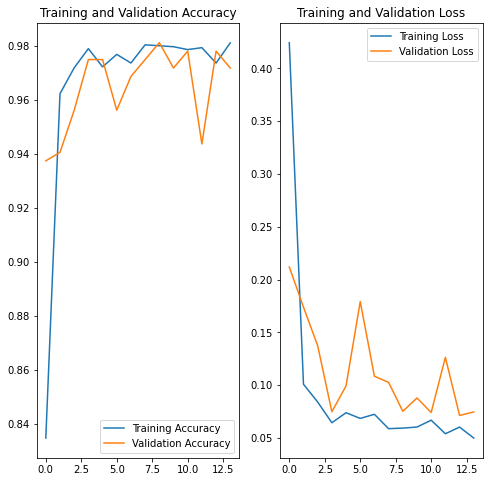

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(14), acc, label='Training Accuracy')
plt.plot(range(14), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(14), loss, label='Training Loss')
plt.plot(range(14), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [53]:
import numpy as np

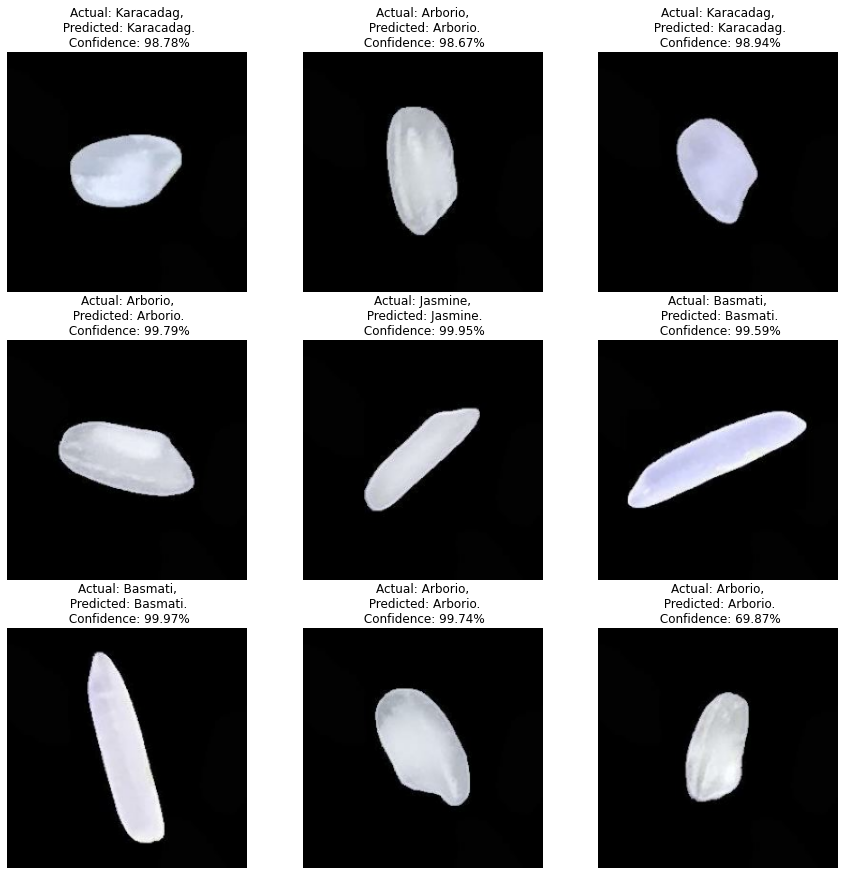

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classnames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
model_version=1
model.save(f"../models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/1\assets
